# About

Same as `RF_glacier.ipynb` but uses GradientBoosting algorithm instead

# Install dependencies

In [ ]:
import sys
!{sys.executable} -m pip install pillow matplotlib scikit-image scikit-learn

# Load libraries & define paths

In [1]:
import numpy as np
from skimage.io import imsave, imread
from skimage.segmentation import slic
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, auc, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import cv2 as cv # need to execute "pip install opencv-python" in the terminal to install module
import numpy as np
import os
import rasterio
from skimage import exposure, filters
from skimage.morphology import square
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import seaborn as sns

In [2]:
# this is the path to the images from your current folder. To adapt
INPUT_DIR = "data/"

# 1. Create train/val/test sets
Use same data as that generated for `RF_glacier.ipynb`

### Split dataset into train/validation/test

Create list of features for each year, with label\
Features are :

SPECTRAL
- BO2_norm (B)
- B03_norm (G)
- B04_norm (R)
- NDWI
- NDSI
- SWIR ( 2 bands: B12, B8A)

MORPHOLOGICAL
- Sobel
- Sobel_v
- sobel_h
- autolovel
- entropy
- gabor
- meijering
- hessian

In [22]:
# Defining which images will belong to the train, test, and validation sets
train_dates = ['2018_0407', '2018_2907', '2019_0308', '2019_2210', '2020_0609', '2020_2110'] 
#validation_validation = [..]
test_dates = ['2017_0808', '2021_2208']


# List of features to use --> TO ADAPT: add SWIR
feature_list = ['B02_norm.npy', 'B03_norm.npy', 'B04_norm.npy', 'B12_norm.npy', 'B8A_norm.npy', 'NDWI.npy', 'NDSI.npy', 
                'sobel.npy', 'sobel_v.npy', 'sobel_h.npy', 'autolevel.npy' , 'entropy.npy',
                'gabor.npy', 'meijering.npy', 'hessian.npy']

col_names = ['B02', 'B03', 'B04', 'B12', 'B8A', 'NDWI', 'NDSI', 'sobel', 'sobel_v', 'sobel_h', 
                 'autolovel', 'entropy', 'gabor', 'meijering', 'hessian', 'label', 'date']

# Initialise feature and gt dataframes
df_train = pd.DataFrame(columns=col_names)

df_test = pd.DataFrame(columns=col_names)


for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file
        
        # Extract year and date of current folder
        year = file.split("EO_Browser_images-", 1)[1].split("_", 1)[0]
        date = file.split("EO_Browser_images-", 1)[1]
        
        # Initialise a list of features for a certain year
        features_of_year = []
        
        # Train data
        if date in train_dates:
            print(date)
            for feature in feature_list:
                PATH_FEATURE = CURRENT_PATH = INPUT_DIR + file + "/" + feature
                
                # Open image and add it to the current year's list of features
                feat_img = np.load(PATH_FEATURE)
                # Flatten: 1 column per band. Shape nrows x ncols
                feat_img = feat_img.flatten() # puts all rows on the same line
                features_of_year.append(feat_img.T)

            # Find ground truth for that year and append to array
            GT_PATH = INPUT_DIR + 'gt/binary_gt_' + date + '.npy'
            gt_binary = np.load(GT_PATH)
            features_of_year.append(gt_binary.flatten().T)
            
            # Create array img height x width x (nbr features + 2). The +2 is because the date and label is added
            # One img has 895161 pixels
            nb_pixels = len(feat_img.flatten())
            date_column = np.repeat(date, nb_pixels)
            features_of_year.append(date_column)
            features_label_array = np.array(features_of_year).T
            print(features_label_array.shape)
            
            # Add to dataframe
            df_train = df_train.append(pd.DataFrame(features_label_array, columns=col_names))
            
            print("Added features and ground truth for that date")
        
        
        
        # Test data
        if date in test_dates:
            print(date)
            for feature in feature_list:
                PATH_FEATURE = CURRENT_PATH = INPUT_DIR + file + "/" + feature
                
               ## Open image and add it to the current year's list of features
                feat_img = np.load(PATH_FEATURE)
                # Flatten: 1 column per band. Shape nrows x ncols
                feat_img = feat_img.flatten() # puts all rows on the same line
                features_of_year.append(feat_img.T)

            # Find ground truth for that year and append to array
            GT_PATH = INPUT_DIR + 'gt/binary_gt_' + date + '.npy'
            gt_binary = np.load(GT_PATH)
            features_of_year.append(gt_binary.flatten().T)
            
            # Create array img height x width x 17
            # One img has 895161 pixels
            nb_pixels = len(feat_img.flatten())
            date_column = np.repeat(date, nb_pixels)
            features_of_year.append(date_column)
            features_label_array = np.array(features_of_year).T
            print(features_label_array.shape)
            
            # Add to dataframe
            df_test = df_test.append(pd.DataFrame(features_label_array, columns=col_names))
            
            print("Added features and ground truth for that date")

2020_2110
(895161, 17)
Added features and ground truth for that date
2018_0407
(895161, 17)
Added features and ground truth for that date
2019_0308
(895161, 17)
Added features and ground truth for that date
2017_0808
(895161, 17)
Added features and ground truth for that date
2020_0609
(895161, 17)
Added features and ground truth for that date
2021_2208
(895161, 17)
Added features and ground truth for that date
2019_2210
(895161, 17)
Added features and ground truth for that date
2018_2907
(895161, 17)
Added features and ground truth for that date


In [23]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test

,B02,B03,B04,B12,B8A,NDWI,NDSI,sobel,sobel_v,sobel_h,autolovel,entropy,gabor,meijering,hessian,label,date
0,0.26141497,0.23551764,0.22510988,0.03784423,0.13890143,0.10999281,0.6774404,0.09260082979042836,0.02138267457485199,-0.12919987738132477,233,3.169925001442312,0.0047499985,0.3015191853046417,1.4230362467060331e-05,0.0,2017_0808
1,0.27852216,0.24601696,0.2254151,0.034526717,0.14768498,0.11331239,0.7090177,0.09144073152056888,-0.02691514790058136,-0.1264847368001938,255,3.584962500721156,-0.0008789359,0.30393823981285095,1.4447043213294819e-05,0.0,2017_0808
2,0.23942436,0.23061897,0.19211635,0.03220753,0.14768498,0.15756834,0.70826507,0.10579217444078956,-0.0965014174580574,-0.11433041840791702,205,3.773557262275185,-0.009345735,0.3087622821331024,1.4779848243051674e-05,0.0,2017_0808
3,0.21061225,0.21100904,0.16811134,0.030994179,0.13717276,0.19263761,0.69420123,0.08582897947517328,-0.07438069581985474,-0.09592048823833466,163,3.906890595608518,-0.003611111,0.3157106935977936,1.565900856803637e-05,0.0,2017_0808
4,0.21342021,0.1934135,0.16811134,0.030395184,0.120633535,0.1911516,0.6746121,0.07606967464386061,-0.07535864412784576,-0.07677412033081055,184,3.7735572622751845,-0.002534106,0.32445454597473145,1.6672596757416613e-05,0.0,2017_0808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790317,0.058794707,0.07390191,0.068349846,0.3943907,0.22957595,-0.49176863,-0.580293,0.006240013375847666,0.008735883980989456,0.0012489445507526398,204,2.3898980954642877,0.00084000826,0.027695847675204277,1.0865542066085254e-07,0,2021_2208
1790318,0.062408134,0.074300796,0.07177041,0.40119633,0.23142307,-0.4928024,-0.5832899,0.0034602107130466127,0.004858337342739105,-0.0005853846669197083,212,2.466247897312731,0.0001930684,0.021170705556869507,5.929918600600104e-08,0,2021_2208
1790319,0.06531724,0.07450024,0.07278277,0.413007,0.23881158,-0.47559133,-0.5906341,0.003506718128485959,0.004917945712804794,0.0006387121975421906,127,2.365596230357602,9.2949185e-06,0.023895900696516037,5.958640869607734e-08,0,2021_2208
1790320,0.06752205,0.07651003,0.074485384,0.42478713,0.24958126,-0.46310815,-0.5898479,0.009536186488116952,0.012569986283779144,0.004886016249656677,127,2.054585169337799,0.0011430254,0.01930847577750683,5.959808646593956e-08,0,2021_2208


# 2. Train a Gradient Boosting classifier

In [24]:
classifier = GradientBoostingClassifier(random_state=10)
classifier.fit(X=df_train.iloc[:,:15], y=df_train['label'])

RandomForestClassifier(random_state=10)

# 3. Predict on test set

In [25]:
predictions = classifier.predict(df_test.iloc[:, :15])

In [26]:
img_2017 = predictions[0:895161].reshape((1303, 687)).astype(np.float32)
img_2021 = predictions[895161:].reshape((1303, 687)).astype(np.float32)

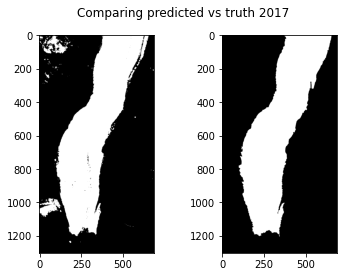

In [27]:
# 2017

GT_PATH = INPUT_DIR + 'gt/binary_gt_2017_0808.npy'
gt_2017 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2017')

ax1.imshow(np.asarray(img_2017), cmap=plt.cm.gray)
ax2.imshow(gt_2017, cmap=plt.cm.gray)

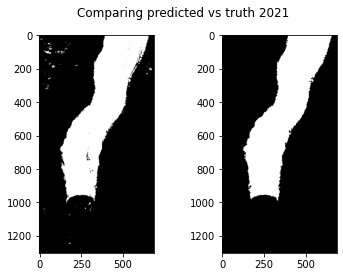

In [28]:
# 2021

GT_PATH = INPUT_DIR + 'gt/binary_gt_2021_2208.npy'
gt_2021 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2021')

ax1.imshow(np.asarray(img_2021), cmap=plt.cm.gray)
ax2.imshow(gt_2021, cmap=plt.cm.gray)

# 4. Model evaluation

In [56]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

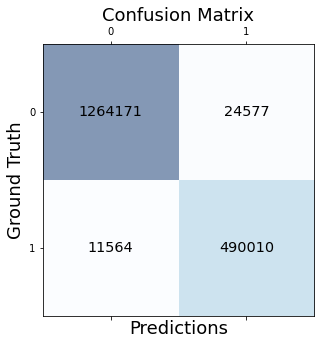

In [57]:
conf_matrix = confusion_matrix(df_test['label'].astype(np.float16), predictions.astype(np.float16))
plot_confusion_matrix(conf_matrix)

### Other metrics

In [39]:
def evaluate_conf(conf_matrix):
    """
    Input: confusion matrix
    =============
    Output: metrics
    """
    
    TP = conf_matrix[1,1]
    FP = conf_matrix[0,1]
    TN = conf_matrix[0,0]
    FN = conf_matrix[1,0]
    
    acc = TP/(FP+TP)
    rec = TP/(FN+TP)
    prec = (TP + TN)/ (TP + FN + TN + FP)
    f1 = 2*prec*rec/ (prec+rec)
    
    print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1)    

"\nacc = accuracy_score(df_test['label'], predictions)\nrec = recall_score(df_test['label'], predictions, average='micro')\nprec =  precision_score(df_test['label'], predictions, average='micro')\nf1 = f1_score(df_test['label'], predictions, average='micro') # Need to fix this one\n#area_uc = roc_auc_score(df_test['label'], predictions, average='micro')\n"

In [40]:
evaluate_conf(conf_matrix)

Accuracy:  0.9391659457360645 
Precision:  0.9672228085443343 
Recall:  0.9730501309205373 
F1:  0.9701277189826353


In [48]:
# With sklearn

acc = accuracy_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
rec = recall_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
prec =  precision_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
f1 = f1_score(df_test['label'].astype(np.float16), predictions.astype(np.float16)) 
area_uc = roc_auc_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))

print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1, 
     "\nArea under ROC: ", area_uc)    

Accuracy:  0.9798131285880417 
Precision:  0.9522393686587496 
Recall:  0.9769445784669859 
F1:  0.9644337855910629 
Area under ROC:  0.9789370659004596


### Feature importance

NDSI         0.171872
B12          0.147564
NDWI         0.109625
B8A          0.092654
B03          0.090465
B02          0.090407
B04          0.081894
meijering    0.043550
entropy      0.037008
sobel        0.031059
autolovel    0.022729
hessian      0.022151
sobel_h      0.021435
sobel_v      0.019038
gabor        0.018547
dtype: float64


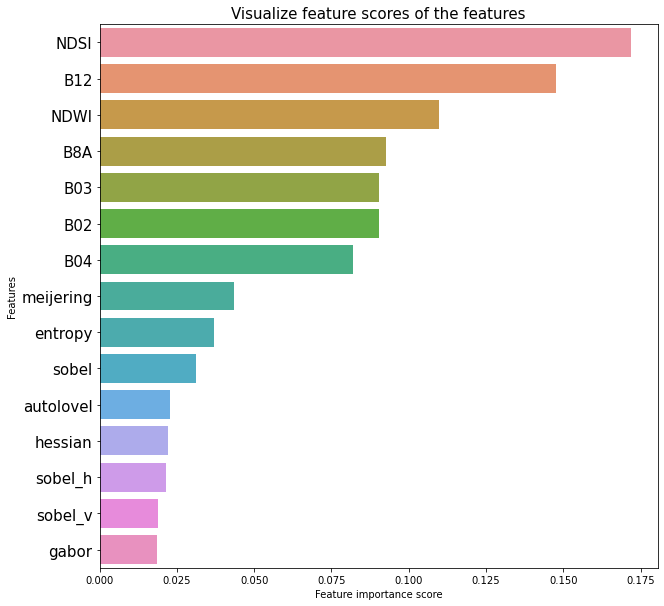

In [58]:
feature_scores = pd.Series(classifier.feature_importances_, index=df_train.iloc[:,:15].columns).sort_values(ascending=False)
print(feature_scores)

# Barplot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features", size=15)
ax.set_yticklabels(feature_scores.index, size=15)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
# realtive feature importance

feature_importance = classifier.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, tr_x.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 5. Hyperparameter tuning

In [62]:
# List of paramaters to evaluate in the validation set
n_estimators_values = [5,50,250,500]
max_depth_values = [1,3,5,7,9]
learning_rate_values = [0.01,0.1,1,10,100]

In [63]:
# Define a validation set (subset of train set)
val_dates = ['2018_2907','2020_0609']
df_val = df_train[df_train['date'].isin(val_dates)]
df_train2 = df_train[~df_train['date'].isin(val_dates)]

In [ ]:
# Initialise best_val_accuracy, best_depth and best_n_estimators
best_val_accuracy = -1
best_depth = None
best_n_estimators = None
best_rate = None

for n_estimators_val in n_estimators_values:
    for max_depth_val in max_depth_values:
        for rate in learning_rate_values:
            
            print("eval n_estimators_val: {} max_depth_val: {} rate: {}".format(n_estimators_val, max_depth_val, rate))
            classifier = GradientBoostingClassifier(random_state=10, n_estimators=n_estimators_val, max_depth=max_depth_val, learning_rate=rate)
            classifier.fit(X=df_train2.iloc[:,:15], y=df_train2['label'])
            val_preds = classifier.predict(df_val.iloc[:, :15])
            val_acc = accuracy_score(df_val['label'].astype(np.float16), predictions.astype(np.float16))

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_depth = max_depth_val
                best_n_estimators = n_estimators_val
                best_rate = rate
                print(val_acc)
            
print("Best max depth: " +str(best_depth))
print("Best number estimators: "+str(best_n_estimators))  
print("Best rate: "+str(best_rate))  

eval n_estimators_val 20 max_depth_val 5 max_feat auto


# 6. Train final GB model & evaluate on test set

In [ ]:
gb_clf = GradientBoostingClassifier(random_state=10, n_estimators=best_n_estimators, max_depth=best_depth)
gb_clf.fit(X=df_train.iloc[:,:15], y=df_train['label'])

In [ ]:
# compute metrics

# 7. Compute ice melting & view results